# Gaussian Mixture Model
12.18 Generate 100 data points from each of the three two-dimensional Gaussian distributions of _Example 12.3_. Plot the data points along with the confidence ellipsoids for each Gaussian with coverage probability 80%. Implement the Gaussian mixture model via the EM algorithm, whose steps are described in Eqs. (12.58)–(12.62). Moreover, compute the log-likelihood function in every iteration of the EM algorithm using Eq. (12.55).

__(a)__ In separate figures (always containing the data), plot the ellipsoids of the Gaussian distributions estimated by the EM algorithm during iterations j = 1, j = 5, and j = 30, and the log-likelihood function versus the number of iterations.

__(b)__ Repeat the experiment after bringing the cluster means closer together. Compare the results

Initialization 1/5
Initialization 2/5
Converged at iteration 27
Initialization 3/5
Converged at iteration 14
Initialization 4/5
Converged at iteration 12
Initialization 5/5
Converged at iteration 5


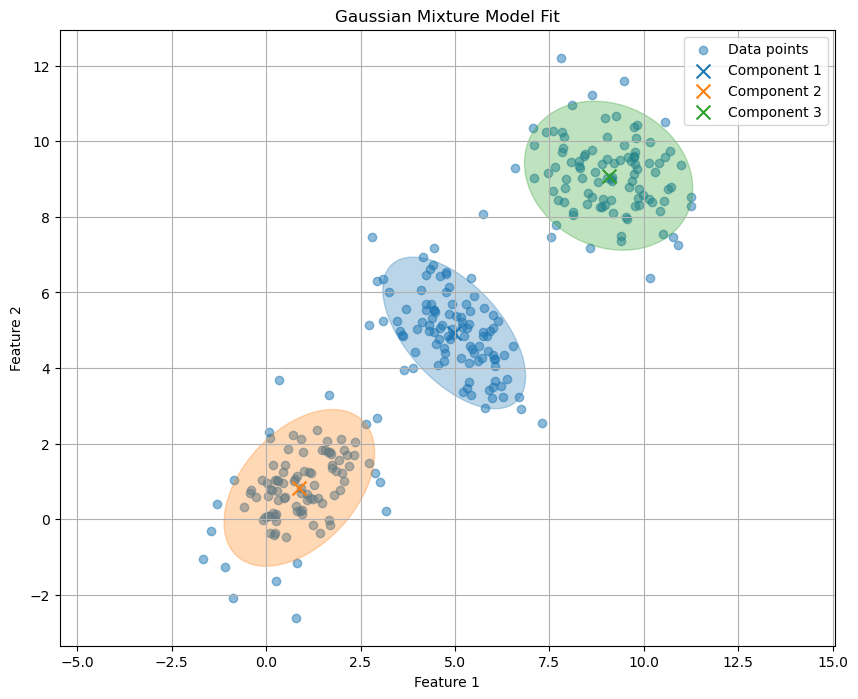

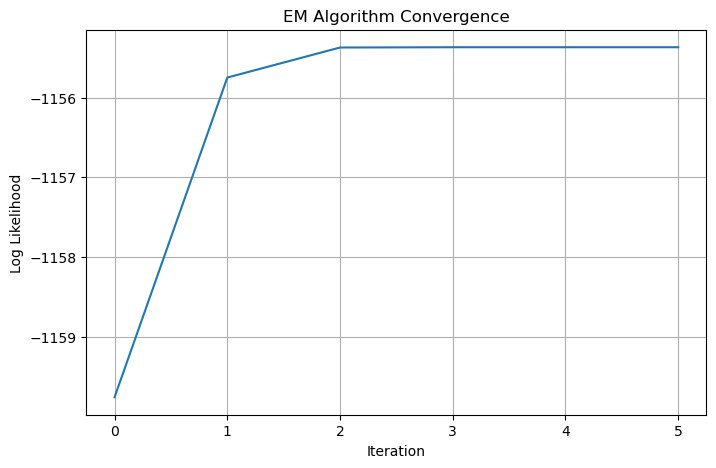

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

class GaussianMixture:
    """
    Gaussian Mixture Model with Expectation-Maximization algorithm
    
    Parameters:
        n_components (int): Number of Gaussian components
        max_iter (int): Maximum EM iterations
        tol (float): Convergence threshold for log likelihood
        random_state (int): Random seed for reproducibility
    """
    def __init__(self, n_components=3, max_iter=100, tol=1e-6, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.means = None
        self.covariances = None
        self.weights = None
        self.log_likelihood_history = []
        self.current_loglike = float('-inf')
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def initialize_parameters(self, X):
        """Initialize means, covariances and weights"""
        n_samples, n_features = X.shape
        
        # Initialize means with random samples from data
        random_indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_indices]
        
        # Initialize covariances as identity matrices
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])
        
        # Initialize equal weights
        self.weights = np.ones(self.n_components) / self.n_components
    
    def fit(self, X, n_init=5, verbose=False):
        """
        Fit the model to data with multiple initializations
        
        Args:
            X (array): Input data (n_samples, n_features)
            n_init (int): Number of initializations to try
            verbose (bool): Whether to print progress
        """
        best_params = None
        best_loglike = float('-inf')
        
        for init in range(n_init):
            if verbose:
                print(f"Initialization {init + 1}/{n_init}")
            
            try:
                # Initialize parameters
                self.initialize_parameters(X)
                self.log_likelihood_history = []
                
                # Run EM iterations
                for iteration in range(self.max_iter):
                    # E-step
                    self._e_step(X)
                    
                    # M-step
                    self._m_step(X)
                    
                    # Check convergence
                    if iteration > 0 and abs(self.log_likelihood_history[-1] - 
                                           self.log_likelihood_history[-2]) < self.tol:
                        if verbose:
                            print(f"Converged at iteration {iteration}")
                        break
                
                # Keep track of best initialization
                if self.current_loglike > best_loglike:
                    best_loglike = self.current_loglike
                    best_params = {
                        'means': self.means.copy(),
                        'covariances': self.covariances.copy(),
                        'weights': self.weights.copy(),
                        'log_likelihood': self.log_likelihood_history.copy()
                    }
                    
            except (ValueError, RuntimeWarning) as e:
                if verbose:
                    print(f"Initialization {init + 1} failed: {str(e)}")
                continue
        
        # Set parameters to best found
        if best_params is not None:
            self.means = best_params['means']
            self.covariances = best_params['covariances']
            self.weights = best_params['weights']
            self.log_likelihood_history = best_params['log_likelihood']
            self.current_loglike = best_loglike
        else:
            raise RuntimeError("All initializations failed")
    # The EM algorithm doesn't know the true μ/Σ/γ - it estimates them from data
    def _e_step(self, X):
        """Expectation step: compute component responsibilities"""
        weighted_probs = np.array([
            self.weights[k] * multivariate_normal.pdf(X, self.means[k], self.covariances[k]) # computes responsibilities using 2D means and 2x2 covariances
            for k in range(self.n_components)
        ])
        self.responsibilities = weighted_probs / weighted_probs.sum(axis=0)
    
    def _m_step(self, X):
        """Maximization step: update parameters"""
        Nk = self.responsibilities.sum(axis=1)
        
        # Update weights
        self.weights = Nk / X.shape[0]  # gamma [1/3, 1/3, 1/3]
        
        # Update means
        self.means = np.array([
            np.sum(self.responsibilities[k].reshape(-1, 1) * X, axis=0) / Nk[k] 
            for k in range(self.n_components)
        ]) # updates means by averaging 2D data points
        
        # update covariances with regularization
        for k in range(self.n_components):
            diff = X - self.means[k] # Checking equation 12-55
            self.covariances[k] = np.dot(self.responsibilities[k] * diff.T, diff) / Nk[k]
            self.covariances[k] += 1e-6 * np.eye(X.shape[1])  # Regularization
        
        # Compute log likelihood
        self.current_loglike = self._compute_log_likelihood(X)
        self.log_likelihood_history.append(self.current_loglike)
    
    def _compute_log_likelihood(self, X):
        """Compute log likelihood of current parameters"""
        probs = np.array([
            self.weights[k] * multivariate_normal.pdf(X, self.means[k], self.covariances[k])
            for k in range(self.n_components)
        ])
        return np.sum(np.log(probs.sum(axis=0)))
    
    def plot_results(self, X):
        """Plot the data and fitted components"""
        plt.figure(figsize=(10, 8))
        
        # Plot data points
        plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Data points')
        
        # Plot component ellipses
        for k in range(self.n_components):
            self._plot_cov_ellipse(
                cov=self.covariances[k], 
                pos=self.means[k],
                nstd=2,
                alpha=0.3,
                color=f'C{k}'
            )
            plt.scatter(self.means[k, 0], self.means[k, 1], 
                       color=f'C{k}', marker='x', s=100,
                       label=f'Component {k+1}')
        
        plt.title('Gaussian Mixture Model Fit')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()
    
    def _plot_cov_ellipse(self, cov, pos, nstd=2, **kwargs):
        """Plot covariance ellipse at given position"""
        eigvals, eigvecs = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
        width, height = 2 * nstd * np.sqrt(eigvals)
        ellipse = Ellipse(pos, width, height, angle=angle, **kwargs)
        plt.gca().add_patch(ellipse)
    
    def plot_convergence(self):
        """Plot the log likelihood convergence"""
        plt.figure(figsize=(8, 5))
        plt.plot(self.log_likelihood_history)
        plt.title('EM Algorithm Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('Log Likelihood')
        plt.grid(True)
        plt.show()

# Generate sample data
np.random.seed(17)
X = np.vstack([                 # mu;mean  | Sigma;covariances | samples
    np.random.multivariate_normal([1, 1], [[1, 0.5], [0.5, 1]], 100),
    np.random.multivariate_normal([5, 5], [[1, -0.5], [-0.5, 1]], 100),
    np.random.multivariate_normal([9, 9], [[1, 0], [0, 1]], 100)
])

# Fit the model
gm = GaussianMixture(n_components=3, random_state=17)
gm.fit(X, n_init=5, verbose=True)

# Plot results
gm.plot_results(X)
gm.plot_convergence()

In [3]:
X.shape

(300, 2)

### Code workflow
1. Initialization (`initialze_parameters`):
    - Randomly select initial means from the data
    - Initialize covariances as identity matrices
    - Set equal weights

2. EM Loop (`fit`):
    - Run multpile initializations (`n_init`) to avoid poor local optima
    - For each initialization
        - E-Step: Compute responsabilities (`_e_step`)
        - M-Step: Update parameters (`_m_step`)
        - Check for convergence using log likelihood

3. Visualization (`plot_results`, `plot_convergence`):
    - Data and fitted Gaussians: Plot data points and the estimated Gaussian ellipses
    - Convergence plot

### References
To see the Equations go to Sergios Theo (2026)